# Game Trends Analysis Project

### Description
This project analyzes historical video game sales data to identify patterns that determine the success of a game.  
The dataset includes information on sales across regions, user and critic ratings, and genres.  

#### Goals:
1. Explore the dataset and clean it for analysis.
2. Identify sales trends across platforms and genres.
3. Create regional user profiles to guide marketing strategies.
4. Test hypotheses related to user ratings and game genres.

#### Import and Study General Information

In [179]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns
from scipy import stats

In [180]:
# Load the dataset and display the first few rows
file_path = './datasets/games.csv'
df = pd.read_csv(file_path)

# Display the first 5 rows
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [181]:
# View basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [182]:
# Check for missing values in each column
df.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [183]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

#### Preparing The Data

In [184]:
# Replace column names with lowercase
df.columns = df.columns.str.lower()

# Convert year_of_release to integer
df['year_of_release'] = df['year_of_release'].astype('Int64')

# Replace 'TBD" values in user_score with NaN and convert to float
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

Changing year_of_release to an integer makes more sense due to the fact that years are always whole numbers.
Additionally, there are missing values (NaN), which require an integer type.

Making user_score numeric is necessary because it represents numeric data. It is originally set as an object because of the value "TBD", which is not numeric and prevents pandas from treating this column as numeric.

These conversions clean up the dataset to ensure consistency.
They also prevent issues when performing analysis. 

In [185]:
# Drop rows with missing values in name and year_of_release, 'name, and 'genre'
df = df.dropna(subset=['year_of_release', 'name', 'genre'])

Dropping the year_of_release for multiple reasons. Without the release year, you wouldn't know how recent or relevant the game is, which makes it unusable for predicting future trends. Furthermore, the missing data is a mere 269 rows. That is less than 2 % of the dataset. So, dropping them wont significantly impact the analysis. Guessing or filling a placeholder year could introduce inaccuracies. 

Dropping the name and genre missing data is also necessary. without a name, the game is unidentifiable. Similarly, the genre is essential for analyzing trends. Also, there are only 4 rows in total missing this data. Dropping them won't affect the analysis in any meaningful way.

In [186]:
# Create a new DataFrame with only rows where Critic_Score is not null
df_valid_critic = df[df['critic_score'].notnull()]

# Check the shape of this filtered DataFrame
print(df_valid_critic.shape)

(7983, 11)


The column critic_score has a lot of missing values. However, this could actually be useful for analysis. Games that weren't reviewed might be insightful - do such games sell less? This can be used further on. 

Creating a separate df that filters out rows with missing values could also prove to be useful. Having that as an option for histograms or other visualizations could help with the analysis. It may not be used but it could be nice to have later on. 

In [187]:
# Create a new DataFrame with rows where User_Score is not null
df_valid_user = df[df['user_score'].notnull()]

# Check the shape to confirm how many rows were retained
print(df_valid_user.shape)

(7463, 11)


Similarly to critic_score, missing values for user_score could be useful for analysis. But it is nice to have the separate filtered dataframe in case it could be useful. 

In [188]:
# Replace 'K-A' with 'E' for simplicity
df['rating'] = df['rating'].replace('K-A', 'E')

K-A rating is outdated. It is essentially just an older way of saying E for Everyone. That being said, replacing the rating would add simplicity. 


In [189]:
# Calculate the total sales for each game and store in a new column
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

# Display the first few rows to confirm the changes
print(df[['name', 'total_sales']].head())

                       name  total_sales
0                Wii Sports        82.54
1         Super Mario Bros.        40.24
2            Mario Kart Wii        35.52
3         Wii Sports Resort        32.77
4  Pokemon Red/Pokemon Blue        31.38


#### Analyze The Data

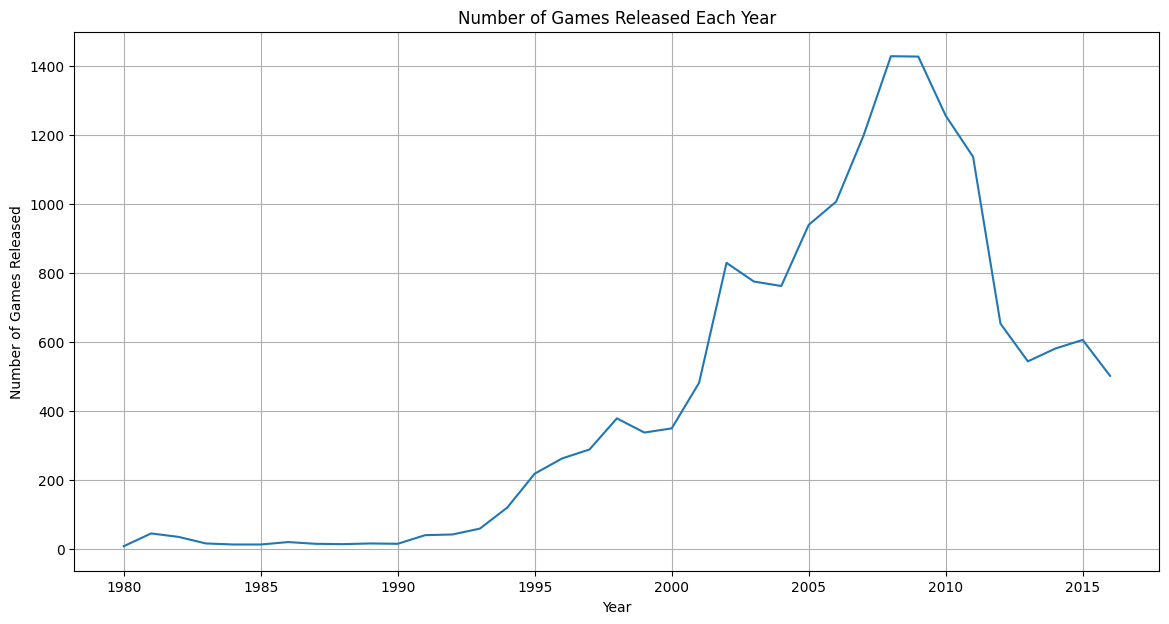

In [190]:
# Group the data year_of_release and count how many games were released each year
games_per_year = df.groupby('year_of_release')['name'].count()

# Visualize the number of games released each year with a bar plot
games_per_year.plot(kind='line', figsize=(14, 7))
plt.title('Number of Games Released Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Games Released')
plt.grid()
plt.show()

Looking at this line chart, it seems like there's a noticeable increase in game releases up until 2008-2009, followed by a decline in the later years. Very few games were released in the early years (1980-1994). That might not provide enough data for meaningful trends.The mid-years (1995-2007) had a steady increase in releases, reflecting a growth period in the gaming industry. The peak (2008-2009) had the highest number of releases. Finally, (2010-2016) the game releases start to drop off.

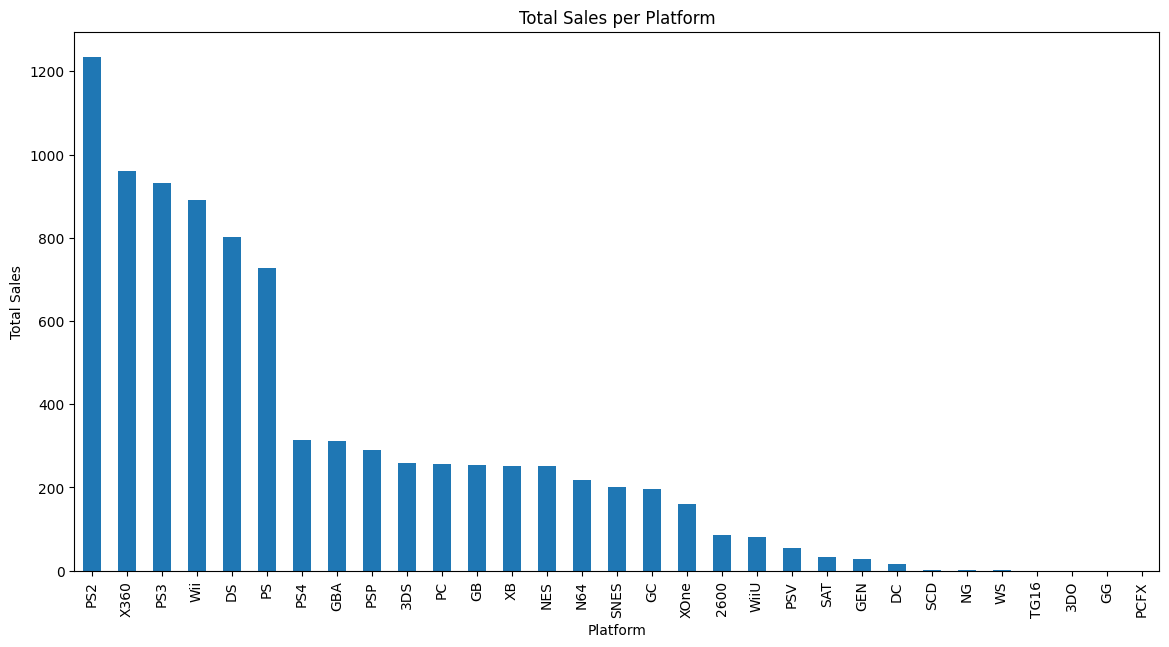

In [191]:
# Look at how the sales varied platform to platform
sales_per_platform = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

# Visualize the total sales per platform with a bar plot
sales_per_platform.plot(kind='bar', figsize=(14, 7))
plt.title('Total Sales per Platform')
plt.xlabel('Platform')
plt.ylabel('Total Sales')

plt.show()

Top Performers:

PS2 leads by a significant margin, followed by Xbox 360, PS3, Wii, and DS.
These platforms were part of very competitive generations with popular titles and significant user bases.
Moderate Performers:

PS4, PSP, PC, Game Boy Advance (GBA), and 3DS occupy the mid-tier range.
These systems also had popular titles but may not have had the same widespread adoption or game libraries as the leaders.
Lower Performers:

Older platforms like NES, SNES, N64, Sega Genesis (GEN), and Atari 2600 rank lower.
This might be due to fewer games released historically or the dataset being incomplete for retro systems.
Very Low Performers:

Platforms like TG16, 3DO, GG, and PC-FX have negligible representation, possibly due to their niche or short-lived nature.

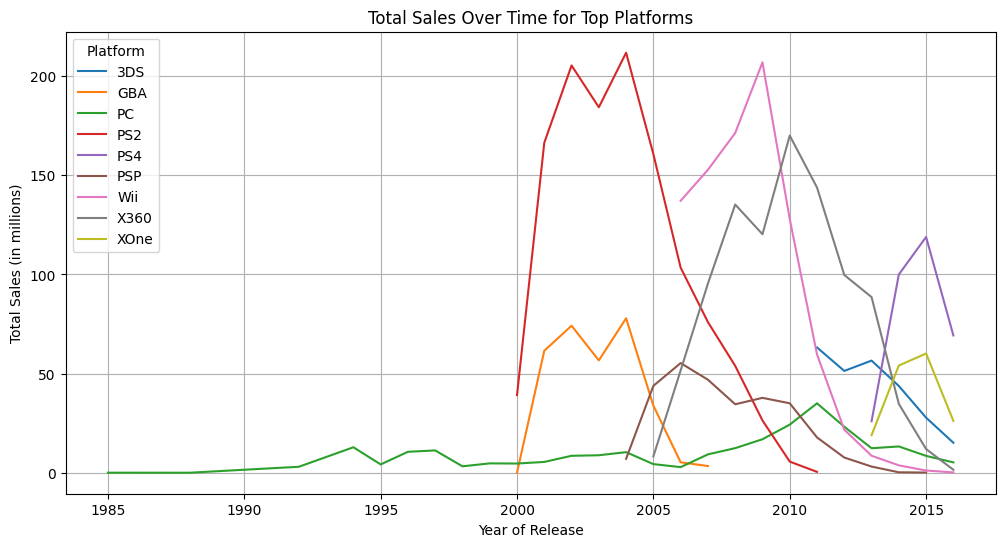

In [193]:
# Ensure no NaN values in year_of_release
df = df.dropna(subset=['year_of_release'])

# Convert year_of_release to integer if needed
df['year_of_release'] = df['year_of_release'].astype(int)

# Ensure total_sales is numeric
df['total_sales'] = pd.to_numeric(df['total_sales'], errors='coerce')

# Define top platforms (make sure this exists)
top_platforms = ['PS4', 'XOne', 'PC', '3DS', 'Wii', 'PS2', 'GBA', 'PSP', 'X360']

# Filter for top platforms
df_top_platforms = df[df['platform'].isin(top_platforms)]

# Check if df_top_platforms is empty
if df_top_platforms.empty:
    print("Filtered DataFrame is empty. Check top_platforms and data.")

# Group by year and platform to calculate total sales
platform_year_sales = df_top_platforms.groupby(['year_of_release', 'platform'])['total_sales'].sum().unstack()

# Plot the data
plt.figure(figsize=(12, 6))
platform_year_sales.plot(kind='line', ax=plt.gca())  # Ensure it plots on the same figure
plt.title('Total Sales Over Time for Top Platforms')
plt.xlabel('Year of Release')
plt.ylabel('Total Sales (in millions)')
plt.legend(title='Platform')
plt.grid()

Platforms That Were Popular but Faded:

PS2: Peaked around the mid-2000s and declined sharply after 2010.
Wii: Had a strong peak around 2008–2010 but also declined rapidly by 2012.
GBA (Game Boy Advance): Faded around 2007 after a strong run in the early 2000s.
Platforms with a Short Lifespan:

Platforms like GBA and PSP had relatively short but intense periods of popularity compared to platforms like PS2, which had a longer lifecycle.
Emerging Platforms:

PS4 and X360 were still going strong toward the end of the data (around 2015), showing they were still relevant.

In [ ]:
# Find platforms with zero sales in the last recorded year
platform_last_sales = df.groupby('platform')['year_of_release'].max()
platform_zero_sales = platform_last_sales[platform_last_sales < df['year_of_release'].max()]
print(platform_zero_sales)

platform
2600    1989
3DO     1995
DC      2008
DS      2013
GB      2001
GBA     2007
GC      2007
GEN     1994
GG      1992
N64     2002
NES     1994
NG      1996
PCFX    1996
PS      2003
PS2     2011
PSP     2015
SAT     1999
SCD     1994
SNES    1999
TG16    1995
WS      2001
XB      2008
Name: year_of_release, dtype: Int64


In [ ]:
# Calculate the lifespan of each platform
platform_lifespan = df.groupby('platform')['year_of_release'].agg(['min', 'max'])
platform_lifespan['lifespan'] = platform_lifespan['max'] - platform_lifespan['min']
print(platform_lifespan)

           min   max  lifespan
platform                      
2600      1980  1989         9
3DO       1994  1995         1
3DS       2011  2016         5
DC        1998  2008        10
DS        1985  2013        28
GB        1988  2001        13
GBA       2000  2007         7
GC        2001  2007         6
GEN       1990  1994         4
GG        1992  1992         0
N64       1996  2002         6
NES       1983  1994        11
NG        1993  1996         3
PC        1985  2016        31
PCFX      1996  1996         0
PS        1994  2003         9
PS2       2000  2011        11
PS3       2006  2016        10
PS4       2013  2016         3
PSP       2004  2015        11
PSV       2011  2016         5
SAT       1994  1999         5
SCD       1993  1994         1
SNES      1990  1999         9
TG16      1995  1995         0
WS        1999  2001         2
Wii       2006  2016        10
WiiU      2012  2016         4
X360      2005  2016        11
XB        2000  2008         8
XOne    

Popular consoles stay relevant for a decade or more. New consoles often replace older generations within 2-5 years. Some examples of platforms that used to be popular but now have zero sales are:
    PS2 - launched in 2000, peaked around 2004-2006, and sales declined by 2011.
    Wii - reached its prime around 2008-2010, with sales dwindling by 2016.

Analysis of the Data

1. Platforms Still Active in 2016:
   Platforms with non-zero sales in 2016:
   - PS4, XOne, 3DS, WiiU, PC (and possibly others with minor sales).
   These platforms are still active and should be included for building the 2017 model.

2. Trends of Old Platforms:
   Older platforms like PS2, PSP, and Wii had their last sales years around 2013–2015. Including these platforms won’t help build a useful model for 2017 as they are no longer relevant.

3. Sales Dynamics:
   Looking at the platforms’ lifespans:
   - Platforms tend to be relevant for 10–11 years after release.
   - Most sales decline sharply 5–8 years after peaking.

I chose to focus on the period from 2007 to 2016 because it captures the most relevant trends for analyzing platform sales and planning for 2017. By 2007, newer platforms such as the PS3, Xbox 360, and Wii were becoming dominant, while older platforms like the PS2 and DS were starting to decline. This time frame includes the emergence of newer generation consoles like the PS4 and Xbox One, which were growing in popularity by the end of the period and are likely to dominate in 2017. Excluding earlier years (2000-2006) reduces noise from outdated platforms no longer contributing significantly to the market, allowing us to focus on platforms that are still active or potentially profitable for the future. This range provides a clear picture of both growing platforms and those phasing out, giving us a solid foundation for analyzing trends.

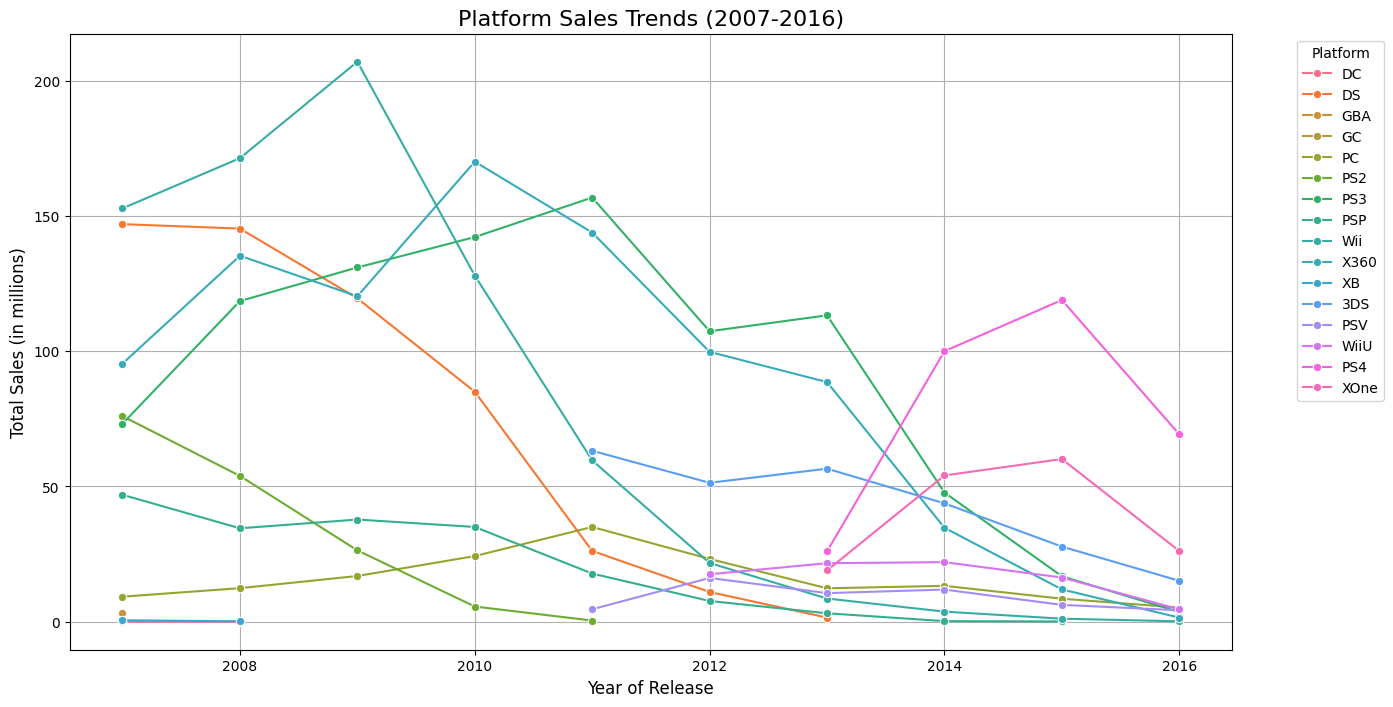

In [ ]:
# Filter the dataset to include only data from 2007 to 2016
recent_data = df[df['year_of_release'].between(2007, 2016)]

# Group by year and platform, summing up sales
recent_platform_sales = recent_data.groupby(['year_of_release', 'platform'])['total_sales'].sum().reset_index()

# Plot the sales trends for platforms in this period
plt.figure(figsize=(15, 8))
sns.lineplot(
    data=recent_platform_sales,
    x='year_of_release',
    y='total_sales',
    hue='platform',
    marker='o'
)
plt.title('Platform Sales Trends (2007-2016)', fontsize=16)
plt.xlabel('Year of Release', fontsize=12)
plt.ylabel('Total Sales (in millions)', fontsize=12)
plt.legend(title='Platform', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

Growing Platforms:

* PS4 and XOne: Both platforms show clear upward trends, with their sales increasing consistently after their release in 2013. These platforms are poised to dominate the market in the near future.

* 3DS: Although not as dominant as the home consoles, its sales have been relatively stable, suggesting potential profitability in the handheld gaming segment.

Shrinking Platforms:

* Wii, PS3, and X360: These platforms were dominant in the earlier years of the period but have seen a clear decline as newer platforms were released.

* PSP and WiiU: Sales remained low and continued to decline, indicating limited profitability.

* PS2: Sales were nearly nonexistent by this time frame, reflecting its phase-out.

Potentially Profitable Platforms:

* PS4: Its strong growth and market adoption make it a highly profitable platform for 2017.

* XOne: Alongside the PS4, it shows strong potential as a top competitor in the market.

* 3DS: As a handheld console, it holds steady sales, making it a niche yet profitable option for targeting specific audiences.

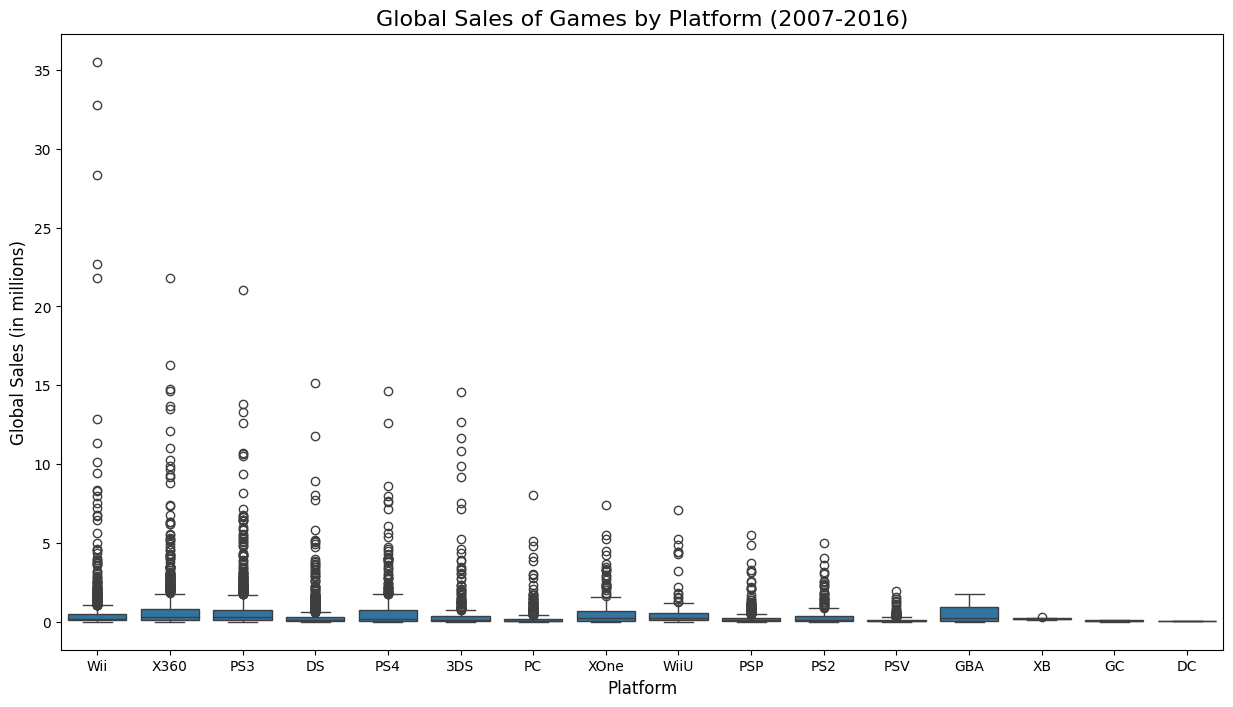

In [ ]:
# Set figure size
plt.figure(figsize=(15, 8))

# Create a boxplot for global sales of games by platform
sns.boxplot(data=recent_data, x='platform', y='total_sales')

# Create a title and labels
plt.title('Global Sales of Games by Platform (2007-2016)', fontsize=16)
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Global Sales (in millions)', fontsize=12)

plt.show()


Based on the boxplot above, we can see that sales differences are significant. Platforms like Wii, X360, PS3, and PS4 have a higher median sales value, meaning their games tend to sell better on average. Some platforms, such as PC, PSV, and Wii U, have a lower median and overall sales distribution, suggesting they may not be as profitable for game releases.

When looking at the average sales by platform, older platforms like PS2 and DS show lower sales in recent years. Newer platforms like PS4 and XOne have increasing game sales, making them more profitable moving forward.

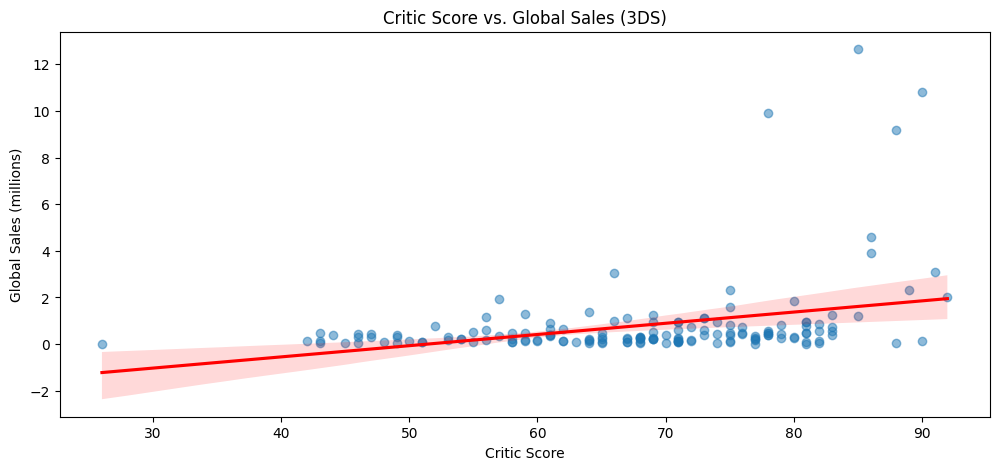

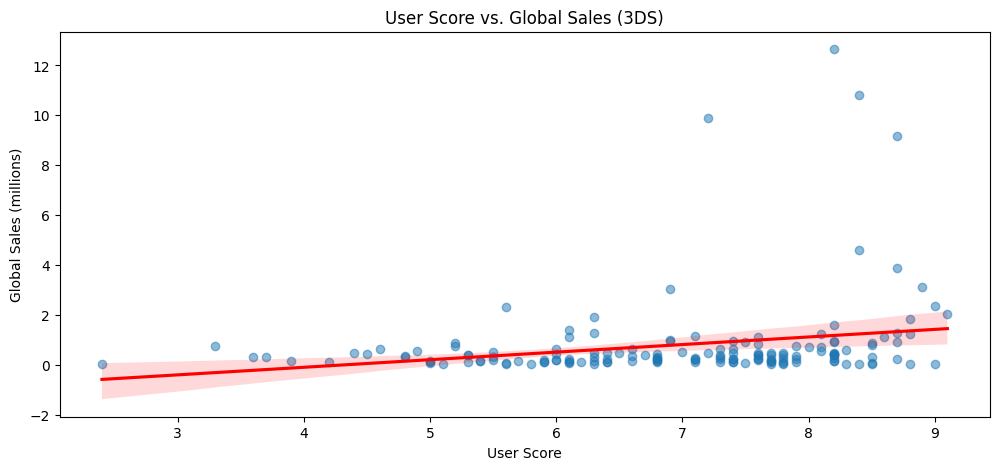

In [ ]:
# Filter data from the 3DS platform
df_3ds = df[df['platform'] == '3DS']

# Drop rows where user or critic scores are missing
df_3ds = df_3ds.dropna(subset=['critic_score', 'user_score'])

# Scatter plot for Critic Score vs. Sales with regression line
plt.figure(figsize=(12, 5))
sns.regplot(data=df_3ds, x='critic_score', y='total_sales', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('Critic Score vs. Global Sales (3DS)')
plt.xlabel('Critic Score')
plt.ylabel('Global Sales (millions)')
plt.show()

# Scatter plot for User Score vs. Sales with regression line
plt.figure(figsize=(12, 5))
sns.regplot(data=df_3ds, x='user_score', y='total_sales', scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.title('User Score vs. Global Sales (3DS)')
plt.xlabel('User Score')
plt.ylabel('Global Sales (millions)')
plt.show()

In [ ]:
# Calculate correlation coefficients
correlation_critic = df_3ds['critic_score'].corr(df_3ds['total_sales'])
correlation_user = df_3ds['user_score'].corr(df_3ds['total_sales'])

print(f'Correlation between Critic Score and Global Sales: {correlation_critic:.3f}')
print(f'Correlation between User Score and Global Sales: {correlation_user:.3f}')

Correlation between Critic Score and Global Sales: 0.339
Correlation between User Score and Global Sales: 0.232


##### Conclusions from the 3DS Game Sales Analysis

1. Critic Scores Have a Moderate Positive Correlation with Global Sales (0.339)
* The scatter plot shows a slight upward trent, indicating that the higher critic scores are generally associated with higher sales.
* However, the spread of data is wide, meaning some low-scoring games still sold well, and some high-scoring games did not perform as expected. 
* The regression line shows a positive slope, but the correlation of 0.339 suggests that critic scores alone do not determine sales - other factors (franchise reputation, advertising, etc.) likely plat a significant role.
2. User Scores Have a Weaker Positive Correlation with Global Sales (0.232)
* The scatter plot for user scores also shows a mild upward trent but is more dispersed than the critic plot.
* The lower correlation suggests that the user reviews have a weaker impact on sales compared to critic scores. 
* A possible explanation is that by the time user scores accumulate, most sales have already been made.
* The presence of outliers suggests that factors beyond user reviews influence sales, such as brand loyalty and marketing. 

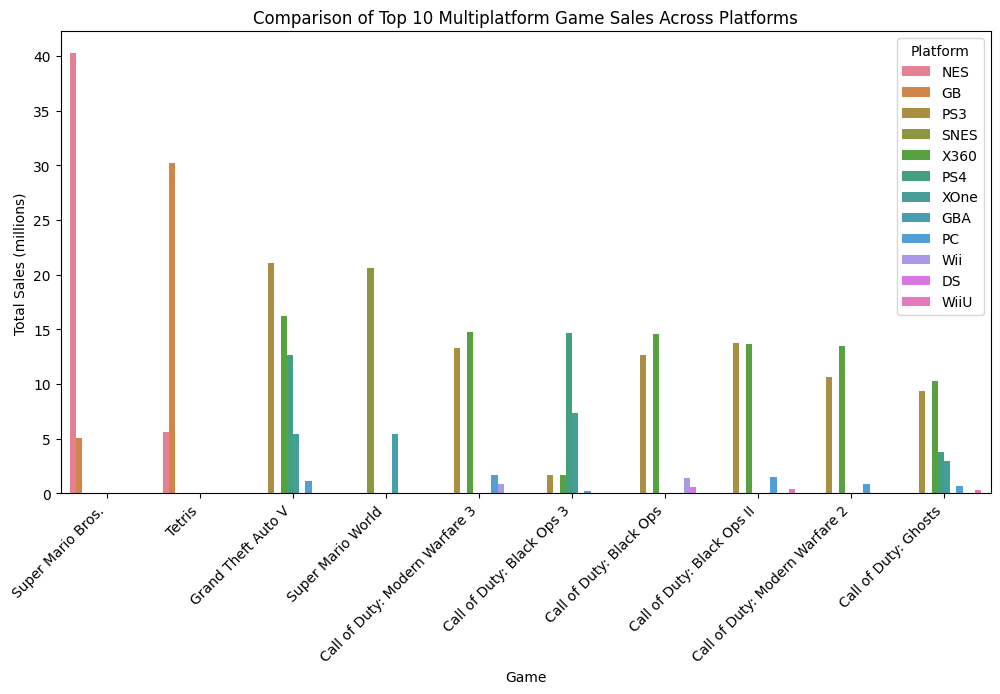

In [ ]:
# Find the top-selling multiplatform games
multi_platform_games = df.groupby('name').filter(lambda x: len(x) > 1)

# Get the top 10 multiplatform games by total sales
top_multi_platform_games = (
    multi_platform_games.groupby('name')['total_sales'].sum()
    .sort_values(ascending=False)
    .head(10)  # Adjust number as needed
    .index
)

# Filter dataset to only include these top-selling multiplatform games
filtered_df = multi_platform_games[multi_platform_games['name'].isin(top_multi_platform_games)]

# Plot the updated bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_df, x='name', y='total_sales', hue='platform', dodge=True)

plt.xticks(rotation=45, ha='right')  # Rotate names for readability
plt.title('Comparison of Top 10 Multiplatform Game Sales Across Platforms')
plt.xlabel('Game')
plt.ylabel('Total Sales (millions)')
plt.legend(title='Platform')
plt.show()

Key Observations:

1.	Older games dominated by original platforms:
* Super Mario Bros. sold the most on NES, and Tetris had massive sales on Game Boy. This suggests that some games were highly successful on their original platforms without needing strong multiplatform support.
2.	Modern games show more balanced sales across platforms:
* Grand Theft Auto V had strong sales across PS3, PS4, X360, and XOne, showing that modern games benefit from multi-platform releases.
* Call of Duty games are distributed relatively evenly across PlayStation and Xbox platforms, reinforcing their appeal across console ecosystems.
3.	Platform matters for total sales:
* Some platforms clearly contributed more to a game’s success.
* For instance, Call of Duty titles sold more on Xbox 360 and PS3 than on PC or WiiU.

Connecting to Earlier Conclusions:

* Since critic and user scores had moderate correlations with sales (0.339 and 0.232), platform availability and install base likely play a bigger role in total sales than review scores alone.
* Games that appeared on more platforms (GTA V, Call of Duty, etc.) tend to have higher total sales than single-platform games.

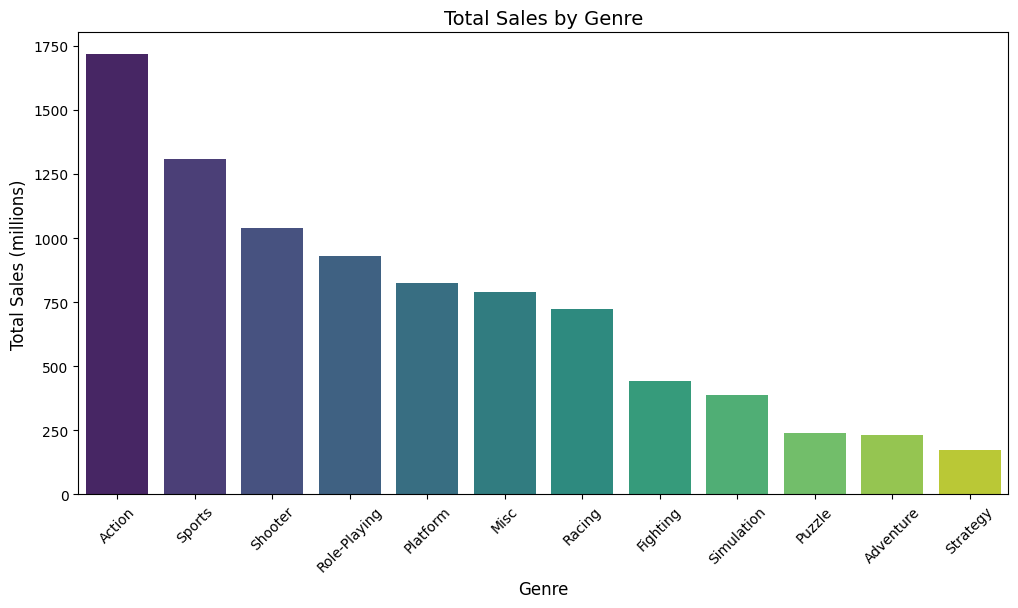

In [ ]:
# Group by genre and sum total sales
genre_sales = df.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_sales.index, y=genre_sales.values, hue=genre_sales.index, palette='viridis', legend=False)

# Labels and title
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Total Sales (millions)", fontsize=12)
plt.title("Total Sales by Genre", fontsize=14)
plt.xticks(rotation=45)
plt.show()

Observations:

1. Most Profitable Genres:
* Action is by far the highest-selling genre, followed by sports and shooter. 
* Role-playing and platform games also generate high sales.
2. Lower-Selling Genres:
* Puzzle, adventure, and strategy games have significantly lower sales.
* Simulation and fighting games sit in the middle but are still much lower than the top genres.

Generalization: 

1. High-Sales Genres tend to have:
* Fast-paced gameplay, multiplayer options, or competitive elements.
* Strong franchises with regular releases.
* Wide appeal across different regions.
2. Low-Sales Genres tend to:
* Have niche audiences.
* Be more focused on single-player experiences.
* Not recieve as much marketing push compared to bloclbuster franchises. 

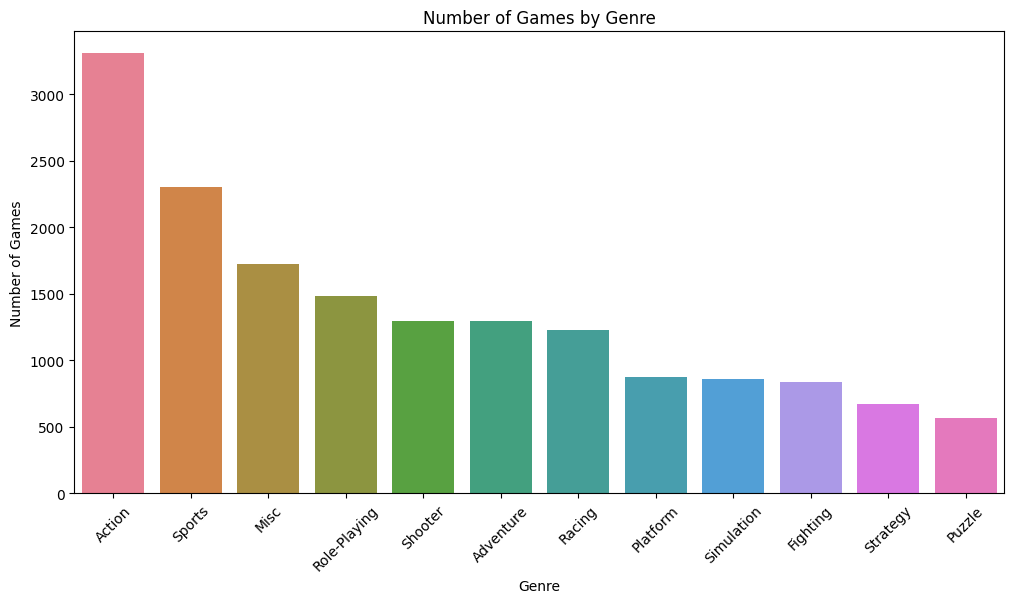

In [ ]:
# Count the number of games per genre
genre_counts = df['genre'].value_counts()

# Create a bar plot
plt.figure(figsize=(12,6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, hue=genre_counts.index, legend=False)

# Add labels and title
plt.xlabel("Genre")
plt.ylabel("Number of Games")
plt.title("Number of Games by Genre")
plt.xticks(rotation=45)
plt.show()

Observations:

1. Action and sports games dominate in both sales and count
* Action games have the most releases and the highest sales.
* Sports games also have high sales and a large number of releases, but fewer than action games.
2. Shooter and role-playing games have high sales but fewer releases
* Shooter and RPG genres rank high in total sales but have fewer games than some of the lower-selling genres.
* This suggests that individial games in these genres tend to sell better on average. 
3. Misc has a high game count but lower total sales
* A large number of Misc games exist, but they don't generate as much revenue collectively. 
* This could indicate niche or low-budget titles that don't sell as well per game. 
4. Puzzle and strategy games have the lowest sales and game count
* Fewer games are released in these genres, and they generate lower total sales. 

Generalizing High vs. Low-Sales Genres:

* High-Sales Genres: action, sports shooter and RPG. These genres tend to have blockbuster franchises and strong fan bases.

* Low-Sales Genres: puzzle, strategy, and simulation. These may have niche audiences or rely on different monetization models. 

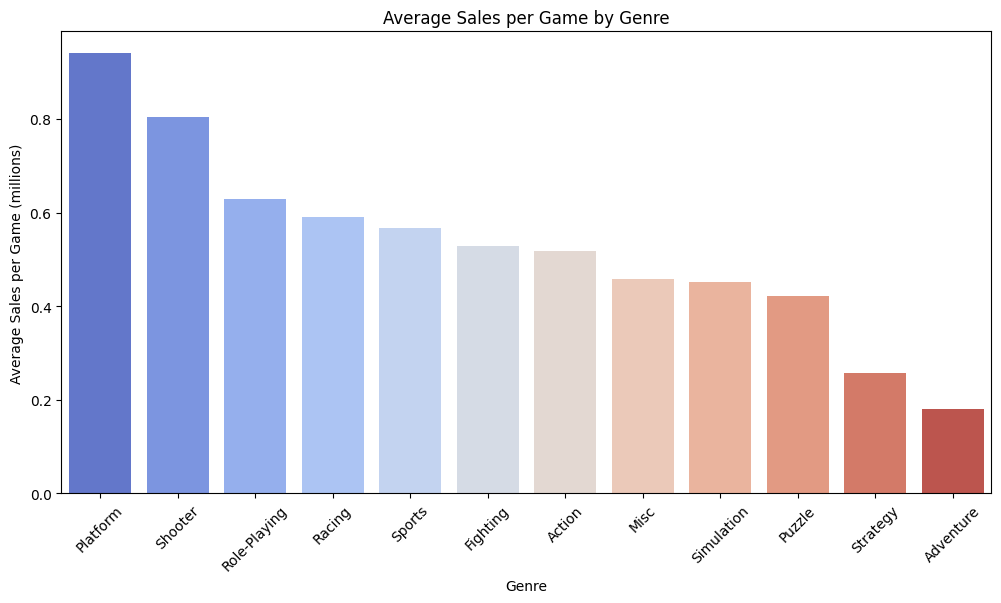

In [ ]:
# Calculate average sales per game for each genre
avg_sales_per_game = genre_sales / genre_counts

# Sort values for better visualization
avg_sales_per_game = avg_sales_per_game.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_sales_per_game.index, y=avg_sales_per_game.values, palette='coolwarm', hue=avg_sales_per_game.index, legend=False)
plt.xlabel('Genre')
plt.ylabel('Average Sales per Game (millions)')
plt.title('Average Sales per Game by Genre')
plt.xticks(rotation=45)
plt.show()

1.	Platformers and Shooters dominate in sales per game
* Even though Action games had the highest number of releases, Platform and Shooter games seem to perform better on a per-game basis.
* This suggests that while Action games are abundant, their average sales per game are lower than these top-performing genres.
2.	Role-Playing, Racing, and Sports also perform well
* These genres have decent average sales, likely due to strong franchises.
* Racing games performing well suggests that the genre has a dedicated, high-spending player base.
3. Adventure and Strategy games struggle in sales per game
* Despite many releases, Adventure and Strategy games have the lowest average sales.
* These genres might be more niche or have a dedicated but smaller player base compared to more mainstream genres like Shooters or Sports.
* It could also mean that these games are less reliant on mass-market appeal and more focused on smaller, passionate audiences.

Business Insights for 2017:

* If Ice is planning an ad campaign, focusing on Platformers, Shooters, or RPGs could be more profitable since they historically have higher sales per game.

* If Ice specializes in Strategy or Adventure games, it may need a different marketing approach, like targeting niche communities or emphasizing unique gameplay elements.

#### Creating User Profiles For Each Region

In [ ]:
# Get top 5 platforms for each region
top_platforms_na = df.groupby('platform')['na_sales'].sum().nlargest(5)
top_platforms_eu = df.groupby('platform')['eu_sales'].sum().nlargest(5)
top_platforms_jp = df.groupby('platform')['jp_sales'].sum().nlargest(5)

# Combine into a DataFrame for easier comparison
top_platforms = pd.DataFrame({
    'NA Sales': top_platforms_na,
    'EU Sales': top_platforms_eu,
    'JP Sales': top_platforms_jp
}).fillna(0)

# Display results
top_platforms

,NA Sales,EU Sales,JP Sales
platform,,,
3DS,0.00,0.00,100.62
DS,380.31,0.00,175.02
PS,0.00,212.39,139.78
PS2,572.92,332.63,137.54
PS3,390.13,327.21,0.00
SNES,0.00,0.00,116.55
Wii,486.87,258.32,0.00
X360,595.74,268.32,0.00


Platform Popularity Differences Across Regions

* Xbox 360 dominates in NA but has almost no sales in JP.
* PlayStation is strong worldwide, but PS2 was the most globally dominant.
* Nintendo’s Wii and DS series performed well everywhere, but especially in JP.
* Europe leans more toward PlayStation, while NA favors Xbox.

In [ ]:
# Get top 5 genres for each region
top_genres_na = df.groupby('genre')['na_sales'].sum().nlargest(5)
top_genres_eu = df.groupby('genre')['eu_sales'].sum().nlargest(5)
top_genres_jp = df.groupby('genre')['jp_sales'].sum().nlargest(5)

# Combine into a DataFrame
top_genres = pd.DataFrame({
    'NA Sales': top_genres_na,
    'EU Sales': top_genres_eu,
    'JP Sales': top_genres_jp
}).fillna(0)

# Display results
top_genres

,NA Sales,EU Sales,JP Sales
genre,,,
Action,863.17,510.99,160.14
Misc,399.57,210.60,107.02
Platform,444.44,0.00,130.71
Racing,0.00,234.49,0.00
Role-Playing,0.00,0.00,353.39
Shooter,584.83,314.52,0.00
Sports,671.20,371.33,134.93


Genre Popularity Differences Across Regions

* Action games are #1 globally, but much bigger in NA and EU than JP.
* Sports games dominate NA and EU but are much less relevant in JP.
* Shooters thrive in NA/EU but are almost nonexistent in JP.
* RPGs dominate JP but don’t appear in the top 5 for NA/EU.
* Racing is big in EU but irrelevant in NA and JP.
* Platformers sell well in JP and NA but are almost absent in EU.

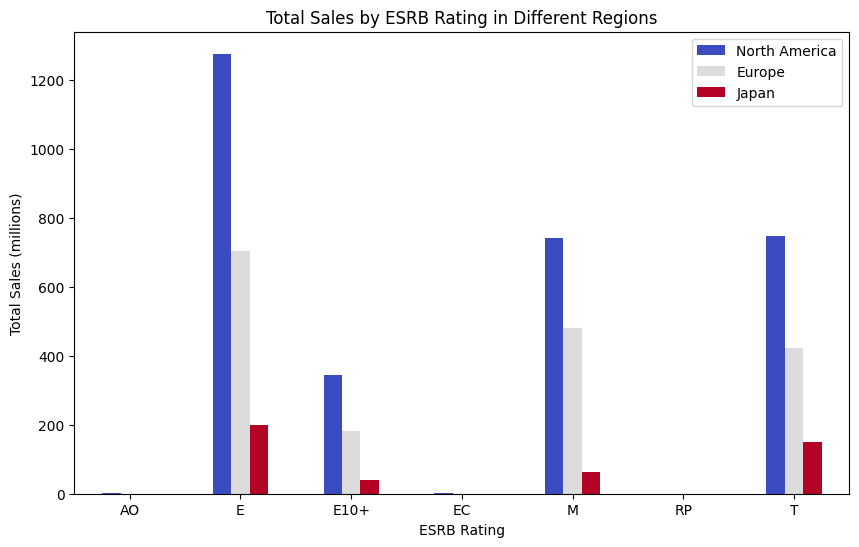

In [ ]:
# Group data by ESRB rating and sum sales for each region
rating_sales = df.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum()

# Plot sales by ESRB rating for each region
rating_sales.plot(kind='bar', figsize=(10, 6), colormap='coolwarm')

# Customize plot
plt.title('Total Sales by ESRB Rating in Different Regions')
plt.xlabel('ESRB Rating')
plt.ylabel('Total Sales (millions)')
plt.xticks(rotation=0)
plt.legend(['North America', 'Europe', 'Japan'])

# Show plot
plt.show()

Conclusion on ESRB rating affecting sales in indivual regions:

* North America prefers E and M-rated games.
* Europe follows a similar pattern but with slightly lower M-rated sales.
* Japan prefers Role-Playing games (as seen earlier) and doesn’t favor M-rated titles.

#### Testing Hypotheses

In [ ]:
# Ensure 'user_score' is numeric
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

# Drop missing values in 'user_score'
df = df.dropna(subset=['user_score'])

# Set significance level (alpha)
alpha = 0.05  # 5% significance level

# Hypothesis 1: Xbox One vs. PC user ratings
xbox_ratings = df[df['platform'] == 'XOne']['user_score']
pc_ratings = df[df['platform'] == 'PC']['user_score']

# Perform independent t-test
t_stat_xbox_pc, p_value_xbox_pc = stats.ttest_ind(xbox_ratings, pc_ratings, equal_var=False)

print(f"T-statistic (Xbox One vs. PC): {t_stat_xbox_pc:.4f}")
print(f"P-value (Xbox One vs. PC): {p_value_xbox_pc:.4f}")

if p_value_xbox_pc < alpha:
    print("We reject the null hypothesis. The average user ratings for Xbox One and PC are significantly different.")
else:
    print("We fail to reject the null hypothesis. No significant difference in average user ratings for Xbox One and PC.")

# Hypothesis 2: Action vs. Sports genre user ratings
action_ratings = df[df['genre'] == 'Action']['user_score']
sports_ratings = df[df['genre'] == 'Sports']['user_score']

# Perform independent t-test
t_stat_action_sports, p_value_action_sports = stats.ttest_ind(action_ratings, sports_ratings, equal_var=False)

print(f"\nT-statistic (Action vs. Sports): {t_stat_action_sports:.4f}")
print(f"P-value (Action vs. Sports): {p_value_action_sports:.4f}")

if p_value_action_sports < alpha:
    print("We reject the null hypothesis. The average user ratings for Action and Sports games are significantly different.")
else:
    print("We fail to reject the null hypothesis. No significant difference in average user ratings for Action and Sports games.")

T-statistic (Xbox One vs. PC): -4.6711
P-value (Xbox One vs. PC): 0.0000
We reject the null hypothesis. The average user ratings for Xbox One and PC are significantly different.

T-statistic (Action vs. Sports): 1.7894
P-value (Action vs. Sports): 0.0737
We fail to reject the null hypothesis. No significant difference in average user ratings for Action and Sports games.


* The Xbox One vs. PC result tells us that player ratings differ significantly between these platforms. Maybe PC players rate games differently than console players?
* The Action vs. Sports result suggests that user ratings for these two genres are fairly similar, at least statistically.

Explanation:

1. Xbox One vs. PC User Ratings

* Null Hypothesis: The average user ratings for Xbox One and PC are the same.
* Alternative Hypothesis: The average user ratings for Xbox One and PC are different.

We assume no difference unless the data provides strong evidence to suggest otherwise.

2. Action vs. Sports User Ratings

* Null Hypothesis: The average user ratings for Action and Sports games are the same.
* Alternative Hypothesis: The average user ratings for Action and Sports games are different.

Again, we assume the ratings are similar unless the test provides strong evidence of a difference.

Significance Level (Alpha) and Why We Chose It

We used a = 0.05, which is a standard threshold in hypothesis testing. This means we are willing to accept a 5% chance of incorrectly rejecting the null hypothesis.
	•	Why 0.05? It strikes a balance between being too strict and too lenient.
	•	For Xbox One vs. PC: The p-value was 0.0000, much smaller than 0.05, so we reject the hypothesis.
	•	For Action vs. Sports: The p-value was 0.0737, slightly above 0.05, so we fail to reject the hypothesis.

If we had used a = 0.10, we might have rejected the null hypothesis for Action vs. Sports, but 0.05 is a more conventional choice.


#### General Conclusion:

This analysis of video game sales identified key trends to guide “Ice” in planning for 2017.

Key Insights:

* Sales peaked between 2005–2010 but declined afterward.

* Top platforms varied by region: Xbox and PlayStation dominated in NA/EU, while Nintendo handhelds led in JP.

* Popular genres: Shooter and Action were top in NA/EU, while JP favored Role-Playing games.

* ESRB ratings influenced sales: “E” rated games sold best, while “M” rated games performed well in NA/EU but not in JP.

* Hypothesis testing: Xbox One and PC had significantly different user ratings, but Action and Sports games showed no significant rating difference.

Business Recommendations:

1.	Focus marketing on top genres per region (Shooter/Action in NA/EU, RPG in JP).

2.	Target active platforms (PS4, XOne in NA/EU, 3DS in JP).

3.	Leverage ESRB rating trends in advertising.

These insights will help “Ice” optimize game selection and marketing for 2017.